In [4]:
!pip install opendatasets --quiet

In [5]:
import torch
import torch.nn as nn
import os
import glob
import opendatasets as od
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as T
import torch.nn.functional as F
from tqdm import tqdm
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
od.download('https://www.kaggle.com/competitions/carvana-image-masking-challenge/data')

100%|██████████| 24.4G/24.4G [11:10<00:00, 39.1MB/s]



Extracting archive ./carvana-image-masking-challenge/carvana-image-masking-challenge.zip to ./carvana-image-masking-challenge


In [7]:
input_dir='carvana-image-masking-challenge'

In [8]:
metadata=pd.read_csv(input_dir+'/metadata.csv.zip')

In [9]:
with zipfile.ZipFile(input_dir+"/train.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
    
with zipfile.ZipFile(input_dir+"/train_masks.zip", 'r') as zip_ref:
    zip_ref.extractall(".")


In [10]:
train_val=sorted(glob.glob('train/*'))

In [11]:
train_val_images = [s.split("/")[-1].split(".")[0] for s in train_val]

In [12]:
len(train_val_images)

5088

In [13]:
x_train,x_val=train_test_split(train_val_images,test_size=0.85,random_state=42)

In [14]:
len(x_train),len(x_val)

(763, 4325)

In [15]:
x_train[0],x_val[0]

('08a646be6b30_06', '1ba84b81628e_14')

In [16]:
class CarvanaDataset(Dataset):
  def __init__(self,img_id,transform=True):
    self.img_id=img_id
    self.transform=transform
  
  def __len__(self):
    return len(self.img_id)
  
  def __getitem__(self,idx):
    img_id=self.img_id[idx]
    img_path='train/'+img_id+'.jpg'
    mask_path='train_masks/'+img_id+'_mask.gif'
    image=np.asarray(Image.open(img_path))
    mask=np.asarray(Image.open(mask_path).convert("L"))
    if self.transform:
      img_trans=T.Compose([
          T.ToTensor(),
          T.Resize((576,576),antialias=True),
          T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
      ])
      mask_trans=T.Compose([
          T.ToTensor(),
          T.Resize((576,576),antialias=True)
      ])
    return img_trans(image),mask_trans(mask)

In [17]:
train_ds=CarvanaDataset(x_train)
val_ds=CarvanaDataset(x_val)

In [18]:
batch_size=4

In [19]:
train_dl=DataLoader(train_ds,batch_size=batch_size)
val_dl=DataLoader(val_ds,batch_size=batch_size)

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device=get_default_device()
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

In [22]:
def conv_block(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channel,
                  out_channels=out_channel, kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_channel,
                  out_channels=out_channel, kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True)
    )


def up_conv_block(in_channel, out_channel):
  return nn.ConvTranspose2d(in_channels=in_channel, out_channels=out_channel, kernel_size=2,stride=2)

def copy_and_crop(left_tensor,right_tensor):
    _, _, h, w = right_tensor.shape
    crop = T.CenterCrop((h, w))(left_tensor)
    output = torch.cat((crop,right_tensor), 1)
    return output

In [23]:
class UNet(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels
        # self.out_channels = out_channels
        self.conv1 = conv_block(self.in_channels, 64) #
        self.conv2 = conv_block(64, 128) #
        self.conv3 = conv_block(128, 256) #
        self.conv4 = conv_block(256, 512) #
        self.conv5 = conv_block(512, 1024)
        self.conv6 = up_conv_block(1024, 512)
        self.conv7 = conv_block(1024, 512)
        self.conv8 = up_conv_block(512, 256)
        self.conv9 = conv_block(512, 256)
        self.conv10 = up_conv_block(256, 128)
        self.conv11 = conv_block(256, 128)
        self.conv12 = up_conv_block(128, 64)
        self.conv13 = conv_block(128,64)
        self.conv14 = nn.Conv2d(in_channels=64,out_channels=1,kernel_size=(1,1))

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(nn.MaxPool2d(2)(out1))
        out3 = self.conv3(nn.MaxPool2d(2)(out2))
        out4 = self.conv4(nn.MaxPool2d(2)(out3))
        out5 = self.conv5(nn.MaxPool2d(2)(out4))
        out6 = self.conv6(out5)
        out7 = self.conv7(copy_and_crop(out4, out6))
        out8 = self.conv8(out7)
        out9 = self.conv9(copy_and_crop(out3,out8))
        out10 = self.conv10(out9)
        out11 = self.conv11(copy_and_crop(out2,out10))
        out12 = self.conv12(out11)
        out13 = self.conv13(copy_and_crop(out1,out12))
        out = self.conv14(out13)
        return out

In [24]:
model=to_device(UNet(3),device)

In [25]:
def Intersection_over_union(out,mask):
  np_out=out.detach().cpu().numpy()
  np_mask= mask.detach().cpu().numpy()
  intersection = np.logical_and(np_out,np_mask).sum(axis=(2,3)).all()
  union = np.logical_or(np_out,np_mask).sum(axis=(2,3)).all()
  iou = intersection / union if union > 0 else 0.0
  return iou/out.size(0)

def dice_coefficient(out,mask):
  np_out=out.detach().cpu().numpy()
  np_mask= mask.detach().cpu().numpy()
  intersection = np.logical_and(np_out,np_mask).sum(axis=(2,3)).all()
  union = np.logical_or(np_out,np_mask).sum(axis=(2,3)).all()
  dice_score= (2*intersection)/(union + intersection)
  return dice_score/out.shape[0]

def print_result():
  fig,ax=plt.subplots(1,3,figsize=(8,10))
  image,label=train_ds[0]
  image=image.unsqueeze(0).to(device)
  label=label.to(device)
  out=model(image)
  out1=out[:,0,:,:]>0.5
  inverse_transform=T.Normalize(mean=(-0.485/0.229, -0.456/0.224, -0.406/0.225), std=(1/0.229, 1/0.224, 1/0.225))
  ax[0].imshow(inverse_transform(image).squeeze(0).permute(1,2,0).detach().cpu().numpy())
  ax[1].imshow(label.permute(1,2,0).detach().cpu().numpy())
  ax[2].imshow(out1.squeeze(0).detach().cpu().numpy())
  print('\n')

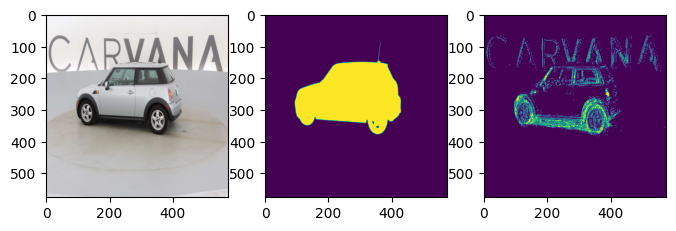

In [26]:
print_result()

In [27]:
epochs=2
lr=0.001
opt_func=torch.optim.Adam
criterion=nn.BCEWithLogitsLoss()
optimizer=opt_func(model.parameters(),lr)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.7)

In [28]:
from tqdm.notebook import tqdm

In [32]:
def fit_one_cycle(epochs,lr_scheduler,model,train_loader,val_loader,optimizer,last_chk_pt=None):
  torch.cuda.empty_cache()
  history=[]
  tr_loss_arr = []
  val_loss_arr = []
  meanioutrain = []
  meaniouval = []
  meandicetrain=[]
  meandiceval=[]
  prev_epoch = 0

  if last_chk_pt!=None:
    checkpoint=torch.load(last_chk_pt)
    prev_epoch=checkpoint['epoch']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for state in optimizer.state.values():
      for k, v in state.items():
        if isinstance(v, torch.Tensor):
          state[k] = to_device(v, device)
          tr_loss_arr =  checkpoint['Training Loss']
    val_loss_arr =  checkpoint['Validation Loss']
    meanioutrain =  checkpoint['IOU train']
    meaniouval =  checkpoint['IOU val']
    meandicetrain =  checkpoint['Dice train']
    meandiceval =  checkpoint['Dice val']
    to_device(model, device)
    
  for epoch in range(epochs):
    # Training Phase 
    model.train()

    pbar=tqdm(train_loader,total=len(train_loader))
    for images,mask in pbar:
      images=images.to(device)
      mask=mask.to(device)
      out= model(images)
      loss=criterion(out,mask)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      tr_loss_arr.append(loss.item())
      meanioutrain.append(Intersection_over_union(out,mask))
      meandicetrain.append(dice_coefficient(out,mask))
      pbar.set_postfix({'Epoch':epoch+1+prev_epoch, 
                        'Training Loss': np.mean(tr_loss_arr),
                        'Mean IOU Train': np.mean(meanioutrain),
                        'Mean DICE Train': np.mean(meandicetrain)
                        })

    # Validation phase
    with torch.no_grad():
          
      pbar = tqdm(val_loader, total = len(val_loader))
      for images,mask in pbar:
        images=images.to(device)
        mask=mask.to(device)
        model.eval()
        out= model(images)

        loss=criterion(out,mask)
        val_loss_arr.append(loss.item())
        meaniouval.append(Intersection_over_union(out,mask))
        meandiceval.append(dice_coefficient(out,mask))
        pbar.set_postfix({'Epoch':epoch+1+prev_epoch, 
                          'Validation Loss': np.mean(val_loss_arr),
                          'Mean IOU Val': np.mean(meaniouval),
                          'Mean DICE Val': np.mean(meandiceval)
                          })
    checkpoint = {
            'epoch':epoch+1+prev_epoch,
            'state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'Training Loss': tr_loss_arr,
            'Validation Loss':val_loss_arr,
            'MeanIOU train':meanioutrain, 
            'MeanDice train':meandicetrain, 
            'MeanIOU val':meaniouval, 
            'MeanDice val':meandiceval
        }
    torch.save(checkpoint, f"model_{epoch+1+prev_epoch}.pth")
    print_result()
    lr_scheduler.step()
  return tr_loss_arr, val_loss_arr, meanioutrain, meaniouval, meandicetrain, meandiceval

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/1082 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/1082 [00:00<?, ?it/s]

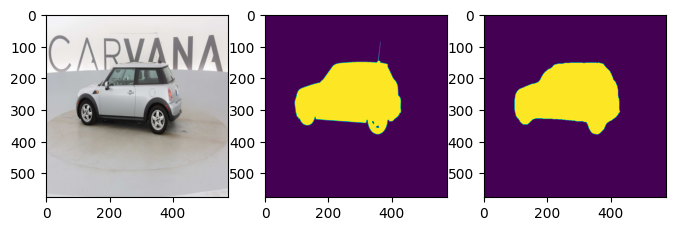

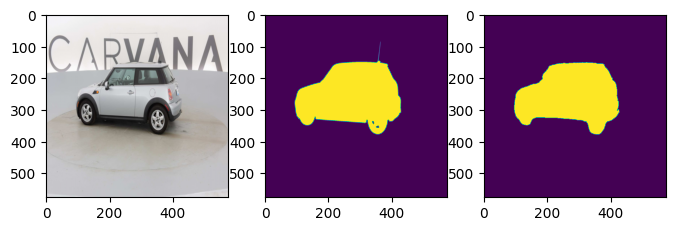

In [33]:
history=[fit_one_cycle(epochs,lr_scheduler,model,train_dl,val_dl,optimizer)]

In [34]:
def print_result():
  fig,ax=plt.subplots(1,3,figsize=(8,10))
  image,label=val_ds[0]
  image=image.unsqueeze(0).to(device)
  label=label.to(device)
  out=model(image)
  out1=out[:,0,:,:]>0.5
  inverse_transform=T.Normalize(mean=(-0.485/0.229, -0.456/0.224, -0.406/0.225), std=(1/0.229, 1/0.224, 1/0.225))
  ax[0].imshow(inverse_transform(image).squeeze(0).permute(1,2,0).detach().cpu().numpy())
  ax[1].imshow(label.permute(1,2,0).detach().cpu().numpy())
  ax[2].imshow(out1.squeeze(0).detach().cpu().numpy())
  print('\n')

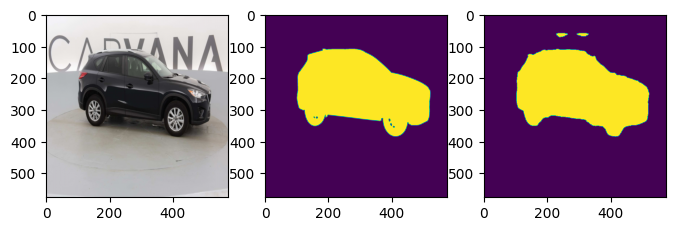

In [35]:
print_result()